# Coursework 1 : The three body problem

You should complete your coursework in this notebook and hand it in *via QMPlus* by 5pm on Friday of week 9 (24 November).

The broad goal of the project is to write code to model coplanar stellar systems (i.e., all the motion is in the x and y directions) with up to three stars.

## Your code must model the following 3 scenarios

1. A two body system made up of two stars with a mass ratio 1:2 undergoing multiple stable orbits (which may be elliptic). The stars obey Newton's law:

    $\vec{F}_{12} = - \frac{G m_1 ~ m_2 }{|r_{12}|^2} \frac{\vec{r}_{12}}{|\vec{r}_{12}|}$

    (You can work in units in which we set $G=1$ and the masses are order 1 numbers, but you can also choose to work in real units, as you prefer.)

2. A three body system made up of 3 stars of equal mass. Stars are assumed to be point like objects and so they cannot collide with each other (they simply pass through if at the same location). Model the stable solution discovered by Cris Moore and proved by Chenciner and Montgomery, described [here](https://arxiv.org/abs/math/0011268) and one in which they display chaotic behaviour, with one star being ejected from the system.

3. You now have a system of hypergiants. Hypergiants are the most massive stars, and so they cannot be treated as point like objects. Now if they get within some distance of each other, they should merge (*HINT: maybe we could say that they "add" themselves...*) into a single hypergiant with a combined mass of the two objects. Since momentum is conserved, we will also require that:

    $(m_1 + m_2)\vec{v}_{new} = m_1 \vec{v}_1 + m_2 \vec{v}_2$

    In this case, set up initial conditions so that you have 3 hypergiants initially, and a few orbits are obtained before a merger of two of the objects. The hypergiants should have 3 similar but different masses, e.g. a ratio of 0.8 : 1.0 : 1.2. You can choose the distance at which they merge, but it should be proportional to the masses of the two objects that are merging.

## Required components

To obtain full marks your solutions must include the following components:

1. Classes for stars, supergiants and stellar systems with multiple star components. Use of inheritance where possible and appropriate 

_(HINT: try to think ahead - what features of scenario 1 might you want to reuse in scenarios 2 and 3? You can save time coding by making it sufficiently general from the start.)_

2. Plots of the orbital trajectories of the stars over time

3. Phase diagrams for the position and velocities of the component stars.

4. Comparison of two explicit integration techniques - the first should be scipy's solve_ivp() and the second should be the midpoint method (or another Runge Kutta method of specified order). For the latter you should confirm the order of convergence of the solution is as expected.

_(HINT: you may want to investigate the rtol parameter for solve_ivp().)_

5. Documentation of the code appropriate for new users who have a basic familiarity with python and ODEs (your colleagues on this course, for example!), implemented in markdown around the code blocks.

6. Defensive programming techniques including asserts and tests of key functionality


## Marking scheme

   - 50% for working code that correctly implements all of the requested physical scenarios
   - 20% for use of defensive programming techniques - asserts and tests implemented to prevent user error and check functioning correctly, including a convergence test
   - 20% for readability of code, following the agreed naming conventions of the course, appropriate commenting
   - 10% for appropriate documentation of the code implemented in markdown format


In [1]:
# Add your coursework here!

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [3]:
%matplotlib inline

## Class Definitions for Star and Stellar System

The star class simply creates objects which have mass, velocity and position. They include some simple checks to prevent user error. Although, the inputs could be simplified if I handled type errors. Using decorators like property and setters allow the user to get information about the object without interacting with the attributes directly.

The StellarSystem is a more comprehensive class with a system based around have a list of stars and their relevant initial conditions. After instantiating a stellar system, it must have 2 stars in order to access more of the functionality. It allows for the trajectories to be computed concisely and plotted with some customisation.

It also includes some separate methods to address the brief, including a midpoint methods ODE calculator and a convergence tester

In [4]:
# Star Class
class Star :
    """
    Defines star object which will work within a stellar system
    
    Attributes: mass (float), position (vector ndarry), velocity (vector ndarray)
    
    Methods: properties and attribute setters
    
    """    
    # constructor function
    def __init__(self, mass=1.0, position=None, velocity=None):
        assert mass > 0, "Mass cannot be less than zero"
        self._mass = float(mass)

        if position is None:
            position = np.array([0.0, 0.0])
        assert isinstance(position, np.ndarray), "Position must be a numpy array"
        assert position.shape == (2,), "Position must be a 2D cartesian vector ie [x,y]"
        self._position = position

        if velocity is None:
            velocity = np.array([0.0, 0.0])
        assert isinstance(velocity, np.ndarray), "Velocity must be a numpy array"
        assert velocity.shape == (2,), "Velocity must be a 2D cartesian vector ie [x,y]"
        self._velocity = velocity

    @property
    def mass(self):
        return self._mass

    @mass.setter
    def mass(self, value):
        assert value > 0, "Mass cannot be less than zero"
        self._mass = float(value)

    @property
    def position(self):
        return self._position

    @position.setter
    def position(self, value):
        assert isinstance(value, np.ndarray), "Position must be a numpy array"
        assert value.shape == (2,), "Position must be a 2D cartesian vector ie [x,y]"
        self._position = value

    @property
    def velocity(self):
        return self._velocity

    @velocity.setter
    def velocity(self, value):
        assert isinstance(value, np.ndarray), "Velocity must be a numpy array"
        assert value.shape == (2,), "Velocity must be a 2D cartesian vector ie [x,y]"
        self._velocity = value

In [5]:
# Class for stellar system of multiple stars
class StellarSystem :
    """
    Defines a collection of stars to calculate their orbital dynamics
    
    Attributes: star list (python list), _num_of_stars (int), _is_defined (bool), 
    
    _solution_found (bool), _lifetime (float), _N_time_steps (int), _delta_t 
    
    _t_solution (values of independent variable t), _y_solution, ndarray(4*Number of Stars, N_time_steps+1)
    
    Methods: add_star : add python list of star objects to star_list, 
            calculate_trajectories: uses explicit integration (RK45 or midpoint) to solve dydt equations and returns solutions for each star, 
            return_initial_conditions: returns flattened list of each stars' position and velocity in order of star_list, 
            plot_trajectories: creates 2D coplanar plot of stars path for duration of lifetime with legend, 
            calculate_accelerations_dydt : derivatives function
            plot_phase_portrait : plot respective positions against velocitys
            plot_velocity_field : plots a quiver plot of trajectories at each position giving a general shape of velocity field
    """
    # Constructor function
    def __init__(self):
        
        self._star_list = []
        self._num_of_stars = 0
        self._is_defined = False
        self._solution_found = False
        print("Stellar system needs at least two stars to be defined")
        
    def add_star(self, star_list):
        assert isinstance(star_list, list), "Star list must be a 1D python list even if it is one star"
        for item in star_list:
            assert isinstance(item, Star) or isinstance(item, HyperGiant), "One or more items in star list is not a star or hypergiant"
        self._star_list.extend(star_list)
        self._num_of_stars = len(self._star_list)
        if self._num_of_stars >= 2:
            self._is_defined = True
            print("System is defined!")
        else:
            print("Stellar system needs at least two stars to be defined")
            
            
    def return_initial_conditions(self):
        """Returns flattened list of each stars' position and velocity in order"""
        # Use list comprehension to gather all positions and velocities
        positions_and_velocities = [np.concatenate([star.position, star.velocity]) for star in self._star_list]
        # Concatenate all arrays at once
        y0 = np.concatenate(positions_and_velocities) 

        return y0
    
    def calculate_accelerations_dydt(self, t, y):
        """Returns flattened list of dydt's calculated from Newton's law - see documentation below"""
        
        assert self._is_defined, "Stellar system needs at least two stars to be defined"
        
        G = 1
        N = self._num_of_stars
        
        # Reshape y to a 2D array for easier manipulation
        y = y.reshape((N, 4))

        # Initialise derivatives (velocities and accelerations)
        dydt = np.zeros_like(y)
        
        for i in range(N): 
            # For each star i in the star list, calculate respective dydt, dvdt
            for j, jstar in enumerate(self._star_list):
                if i != j:
                    
                    # Position vectors for star i and j
                    pos_i = y[i, 0:2]
                    pos_j = y[j, 0:2]

                    # Distance vector and magnitude
                    r_vec = pos_j - pos_i
                    r_mag = np.linalg.norm(r_vec)
                    
                    # Assigning dxdt, dydt to vx vy for each star i
                    dydt[i, 0:2] = y[i, 2:4] 
                    
                    # Using newtons equations for dvxdt dyvdt
                    dydt[i, 2:4] += G * jstar.mass * r_vec / r_mag**3
                    
                    
        return dydt.flatten()
          
    def calculate_trajectories(self, lifetime = 10.0, N_time_steps = 100, method = 'RK45'):
        """Calculate trajectories using solve_ivp Runge-Kutta 4/5 or midpoint method"""
        # Checks for validity of lifetime and N_time_steps input
    
        if not isinstance(lifetime, float):
            raise TypeError("Lifetime must be a float")
        if lifetime <= 0:
            raise ValueError("Lifetime must be a positive float")
        self._lifetime = lifetime
        
        if not isinstance(N_time_steps, int):
            raise TypeError("N_time_steps must be an integer")
        if N_time_steps <= 0:
            raise ValueError("N_time_steps must be a positive integer")
        self._N_time_steps = N_time_steps
        
        assert self._is_defined, "Stellar system needs at least two stars to be defined"
        
        self._delta_t = lifetime / N_time_steps
        self._t_solution = np.linspace(0.0, lifetime, N_time_steps+1) # values of independent variable 
        y0 = self.return_initial_conditions() # initial values y0
        
        if method == 'RK45':
            # Solve ivp wth rk45
            solution = solve_ivp(self.calculate_accelerations_dydt, [0,lifetime], y0, method='RK45', t_eval=self._t_solution)
            self._y_solution = solution.y
            print("Trajectories have been calculated, use .plot_trajectories() to visualise")
            self._solution_found = True
            
        elif method == 'midpoint':
            # Second order runge-kutta method
            self._y_solution = np.zeros((N_time_steps+1, len(y0)))
            for itime, time in enumerate(self._t_solution) :
                if itime == 0 :
                    # Sets initial time point to y0
                    self._y_solution[itime] = y0
                    old_time = time
                else :
                    dydt_at_t = self.calculate_accelerations_dydt(old_time, self._y_solution[itime-1])
                    
                    y_t_plus_half = (self._y_solution[itime-1] + 0.5 *
                                            dydt_at_t * self._delta_t)
                    
                    t_plus_half = old_time + 0.5*self._delta_t
                    
                    dydt_at_t_plus_half = self.calculate_accelerations_dydt(t_plus_half, y_t_plus_half)
                    
                    self._y_solution[itime] = (self._y_solution[itime-1] + 
                                            dydt_at_t_plus_half * self._delta_t) 
                    old_time = time
            # Transpose solutions to correct orientation, initialised in transposed shape to make manipulation easier        
            self._y_solution = self._y_solution.T
            self._solution_found = True
        else:
            raise ValueError("Method has not been implemented, please use either 'RK45' or 'midpoint'")
        
    
    
    def plot_trajectories(self, title = 'Orbits of Stars',axlimit = None):
        assert self._solution_found, "Solution not found: Please use .calculate_trajectories(lifetime, N_time_steps) to find solution"
        
        fig, ax = plt.subplots() # figsize =(10,10)
        
        # allows user to set square ax limits by specifiying a number
        if axlimit is not None:
            assert isinstance(axlimit, float) or isinstance(axlimit, int), 'axlimit must be a float or int to set boundaries of plot'
            ax.set_xlim(-axlimit, axlimit)
            ax.set_ylim(-axlimit, axlimit)
        ax.set(xlabel = 'X',ylabel ='Y', title = f'{str(title)}, lifetime:{self._lifetime},delta t:{self._delta_t}')
        
        
        for i, istar in enumerate(self._star_list):
            # Each stars' x position and y position is stored in index 0 and 1 respectively, and each star has 4 solutions 
            ax.plot(self._y_solution[4*i], self._y_solution[4*i+1],marker = 'o', label = f'star {i+1}, mass:{istar.mass}')
            
        plt.grid()
        plt.legend()
        plt.show()
        
        
    def plot_phase_portrait(self):
        assert self._solution_found, "Solution not found: Please use .calculate_trajectories(lifetime, N_time_steps) to find solution"
        
        fig, axs = plt.subplots(1,2)
        
        # X dxdt portrait
        axs[0].set(xlabel = 'X',ylabel ='dX/dt', title = 'Phase portrait for X against dXdt')
        # Y dydt portrait
        axs[1].set(xlabel = 'Y',ylabel ='dY/dt', title = 'Phase portrait for Y against dYdt')
        
        for i, istar in enumerate(self._star_list):
            # Each stars' x position and dxdt position is stored in index 0 and 2 respectively, and each star has 4 solutions 
            axs[0].plot(self._y_solution[4*i], self._y_solution[4*i+2],'--', label = f'star {i+1}, mass:{istar.mass}')
            
            # Each stars' y position and dydt position is stored in index 1 and 3 respectively, and each star has 4 solutions 
            axs[1].plot(self._y_solution[4*i+1], self._y_solution[4*i+3],'--', label = f'star {i+1}, mass:{istar.mass}')
        
        fig.tight_layout()
        plt.grid()
        plt.legend()
        plt.show()
        
    def plot_velocity_field(self):
        assert self._solution_found, "Solution not found: Please use .calculate_trajectories(lifetime, N_time_steps) to find solution"
        plt.figure()

        # Create a quiver plot with vector arrows given by vx and vy
        for i, istar in enumerate(self._star_list):
            plt.quiver(self._y_solution[4*i], self._y_solution[4*i+1], self._y_solution[4*i+2], self._y_solution[4*i+3], angles='xy', scale_units='xy', scale=2, label = f'star {i+1}, mass:{istar.mass}')

        # Setting the aspect ratio to 'equal' to ensure that the scales on x and y axis are equal
        plt.gca().set_aspect('equal', adjustable='box')

        plt.xlabel('X Position')
        plt.ylabel('Y Position')
        plt.title('Velocity field in 2D space')

        plt.show()

Stellar system needs at least two stars to be defined
System is defined!
Trajectories have been calculated, use .plot_trajectories() to visualise


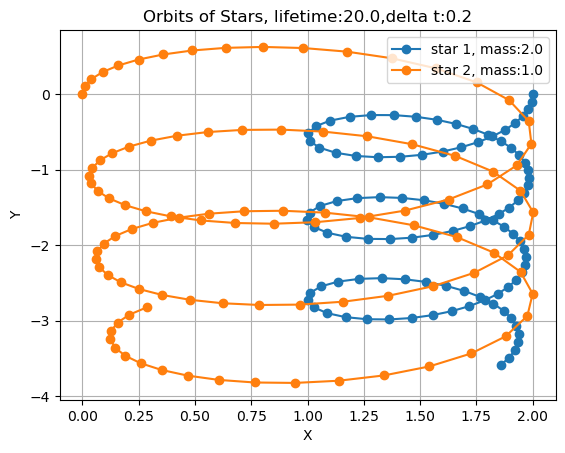

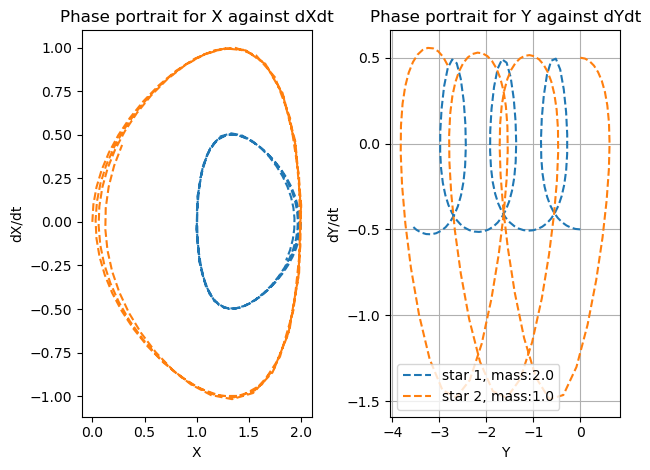

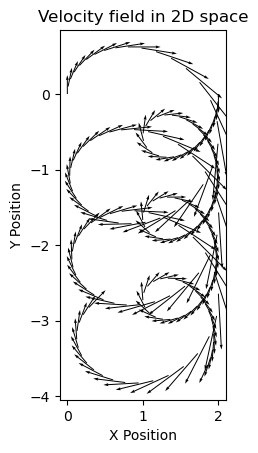

In [6]:
def test_initialisation():
    system = StellarSystem()

    starA = Star(mass = 2, position = np.array([2, 0]), velocity = np.array([0,-0.5]))
    starB = Star(mass = 1, velocity = np.array([0,0.5]))

    system.add_star([starA,starB])
    
    
    system.calculate_trajectories(lifetime= 20.0)
    
    system.plot_trajectories()
    
    system.plot_phase_portrait()
    
    system.plot_velocity_field()
    
test_initialisation()

## Calculating the forces

Each star is under the influence of every other star at every moment. Any pair of stars, eg Star A and Star B - experiences an equal and opposite force exerted on each other calculated by Newton's Law 

$$\vec{F}_A = - \frac{G m_A ~ m_B }{|r_{AB}|^2} \frac{\vec{r}_{AB}}{|\vec{r}_{AB}|}$$

Given we are working in the 2D cartesian plane, each stars' position vector is given by the vector $\vec{x}$ and the relative position vectors can be determined eg. $\vec{r}_{AB} = \vec{x}_B - \vec{x}_A$ . (Note: the sign of G depends on which direction the vector is calculated and will be assumed to be positive from now)

That means every star experiences the sum of forces given by: 
$$\vec{F}_A = G \sum_{i\in \textit{star\_list}} \frac{m_A \cdot m_i}{|x_i - x_A|^3} {(\vec{x_i} - \vec{x_A})}$$

Therefore each stars' acceleration given by Newton's law $\vec{F} = m \vec{a} \implies \vec{a} = \frac{\sum \vec{F}}{m}$ leads to system of differential equations which interact with each other.

$$ \vec{a}_A = \frac{d^2\vec{x}_A}{dt^2} = G \sum_{i\in \textit{star\_list}} \frac{m_i}{|x_i - x_A|^3} {(\vec{x_i} - \vec{x_A})}$$

We can rewrite each of these second-order ODE's into a pair of first-order equations.

$$\frac{d\vec{x}_A}{dt} = \vec{v}_A$$
$$\frac{d\vec{v}_A}{dt} = G \sum_{i\in \textit{star\_list}} \frac{m_i}{|x_i - x_A|^3} {(\vec{x_i} - \vec{x_A})}$$

We have collected these derivatives as vectors, so that technically $\vec{x} = [x, y]$. However, SciPy's solve_ivp and other implementations necessitate that we flatten these vectors in a 1D array.

We can arrange each state vector of stars by its components. It's position and velocity would become: $$ \vec{y}_i = (x_i, y_i, vx_i, vy_i) \implies \frac{d\vec{y}}{dt}_i = (\frac{dx}{dt}_i, \frac{dy}{dt}_i, \frac{dvx}{dt}_i, \frac{dvy}{dt}_i) $$
(Using y and dydt due to convention and readability in code)

Each star's components would be stored in the same order as *star_list* 

Calculate_acceleration_dydt works by taking the list of these stars and assigning components like this: $$ \begin{bmatrix} \frac{dx}{dt}_i \\ \frac{dy}{dt}_i \\ \frac{dvx}{dt}_i \\ \frac{dvy}{dt}_i \end{bmatrix} = \begin{bmatrix} vx_i \\ vy_i \\ \frac{\sum F_x}{m}_i \\ \frac{\sum F_y}{m}_i \end{bmatrix}$$

Solve_ivp and midpoint then numerically solve the equations

## Scenario 1 : A two body system made up of two stars with a mass ratio 1:2 undergoing multiple stable orbits (which may be elliptic).

In [7]:
# Initialise stars with momentums that cancel for stable orbits
starA = Star(mass = 1.0, position = np.array([-1,0]), velocity = np.array([0,1]))

starB = Star(mass = 2.0, position = np.array([1,0]), velocity = np.array([0,-0.5]))
# Initialise star list with needed stars
star_list = [starA,starB]

system1 = StellarSystem()
system1.add_star(star_list)

Stellar system needs at least two stars to be defined
System is defined!


### Runge Kutta 4/5

Trajectories have been calculated, use .plot_trajectories() to visualise


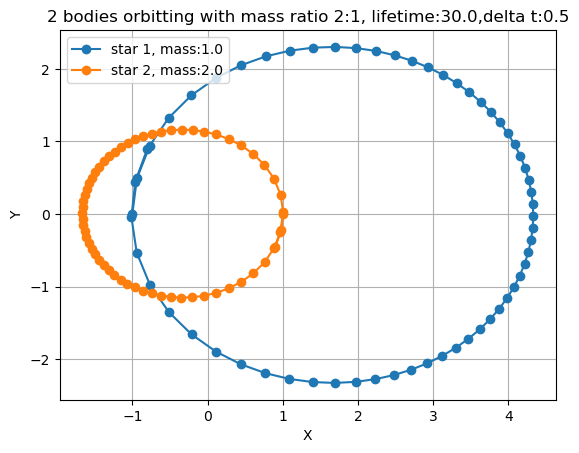

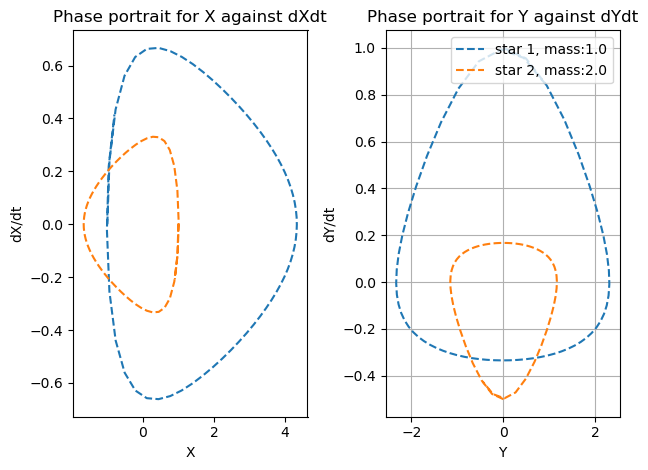

In [8]:
system1.calculate_trajectories(lifetime= 30.0, N_time_steps= 60)
system1.plot_trajectories(title = '2 bodies orbitting with mass ratio 2:1')

system1.plot_phase_portrait()

### Midpoint method with convergence testing
You can begin to see numerical error in the solution after a few orbits

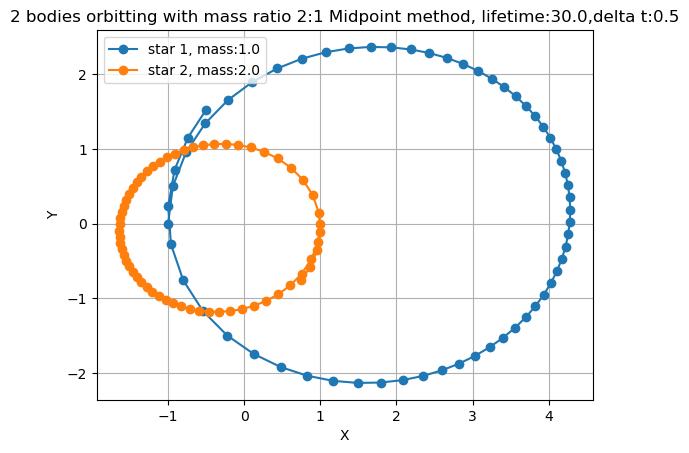

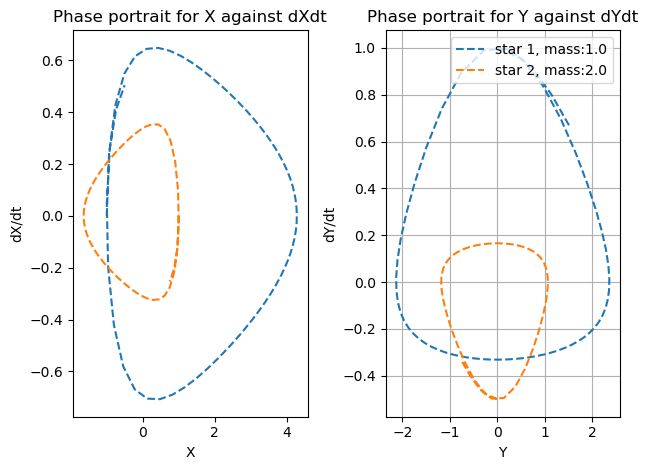

In [9]:
system1.calculate_trajectories(lifetime= 30.0, N_time_steps= 60, method='midpoint')
system1.plot_trajectories(title = '2 bodies orbitting with mass ratio 2:1 Midpoint method')
system1.plot_phase_portrait()

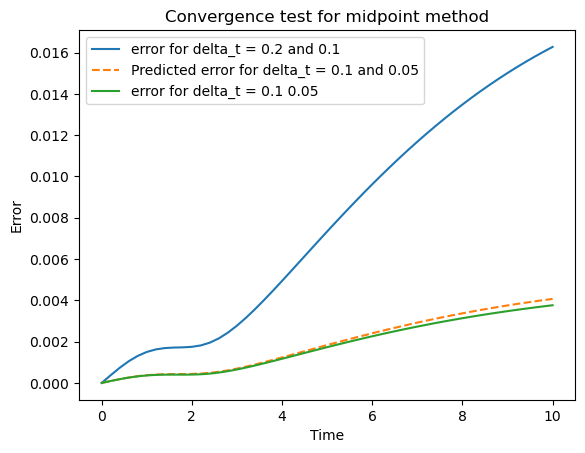

In [15]:
# Test the integrator for the midpoint method - error should decrease 
# by factor of 4 as it is second order
order = 2.0 ** 2.0
solutions = []
solutions_diff = []
error = []


# double the number of steps taken
N_steps_vector = [50,100,200]
for isteps, N_steps in enumerate(N_steps_vector) :
    system1.calculate_trajectories(N_time_steps=N_steps, method='midpoint')
    # store (8,N_time_steps+1) solutions in to list
    solutions.append(system1._y_solution)

# subsample lists and calculate differences at common points to store in array    
# samples 100/2 - 50
solutions_diff.append(solutions[1][:,::2]-solutions[0]) #50 steps
# samples 200/2 - 100
solutions_diff.append(solutions[2][:,::2]-solutions[1]) #100 steps

# subset rows [0:2] for x and y coordinates, solutions diff stores the DIFFERENCE between the step counts
for item in solutions_diff:
    # calculate the norm of the x,y differences to work out absolute error
    error.append(np.linalg.norm(item[0:2], axis = 0))
    
t = system1._t_solution # independent time variable, lifetime is default 10.0

# t stores values for the 200 step calculation
plt.plot(t[::4], error[0], label = 'error for delta_t = 0.2 and 0.1') # subset every 4 to line up with 50 steps
plt.plot(t[::4], error[0]/order, '--', label = 'Predicted error for delta_t = 0.1 and 0.05') # This is predicted error based off order
plt.plot(t[::2], error[1], label = 'error for delta_t = 0.1 0.05') # subset every 2 to line up with 100 steps

plt.title('Convergence test for midpoint method')
plt.xlabel('Time')
plt.ylabel('Error')
plt.legend()
plt.show() 

# we can see the solution error is close to what we'd expect for this order
    

## Scenario 2 : A three body system made up of 3 stars of equal mass
Model the stable solution discovered by Cris Moore and proved by Chenciner and Montgomery, described [here](https://arxiv.org/abs/math/0011268) and one in which they display chaotic behaviour, with one star being ejected from the system.

Stellar system needs at least two stars to be defined
System is defined!
Trajectories have been calculated, use .plot_trajectories() to visualise


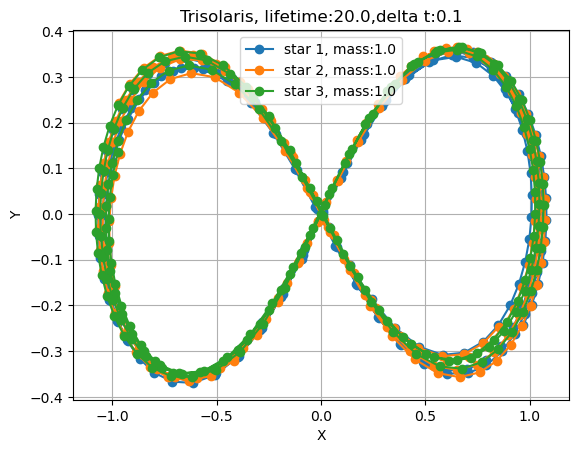

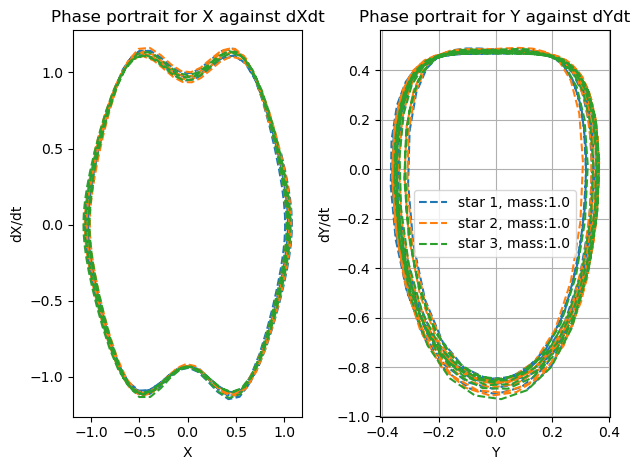

In [11]:
# Initialise stars of equal mass

x1 = np.array([0.97000436,-0.24308753]) # Initial conditions computed by carles simo
v3 = np.array([-0.93240737,-0.86473146])
v1 = -0.5*v3

starA = Star(position = x1, velocity = v1)

starB = Star(position = -x1, velocity = v1)

starC = Star(position = np.array([0,0]), velocity = v3)

starlist = [starA,starB,starC]

system = StellarSystem()
system.add_star(starlist)

system.calculate_trajectories(lifetime= 20.0, N_time_steps= 200)
system.plot_trajectories(title = 'Trisolaris')
system.plot_phase_portrait()

Closed loops tell us the attractor state is stable and the system is convserving energy. Inspirals suggest the system is losing energy and outspirals suggest the system is gaining it.

Stellar system needs at least two stars to be defined
System is defined!
Trajectories have been calculated, use .plot_trajectories() to visualise


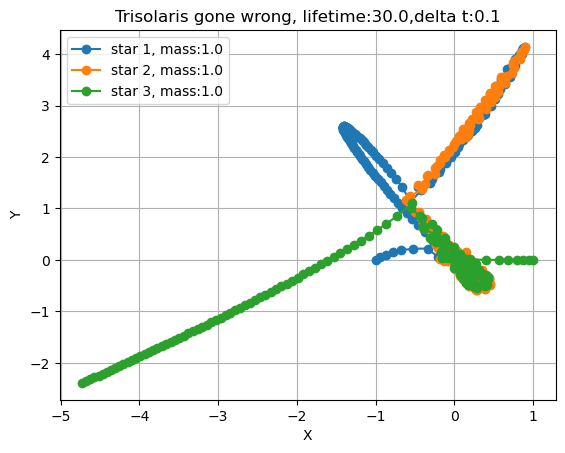

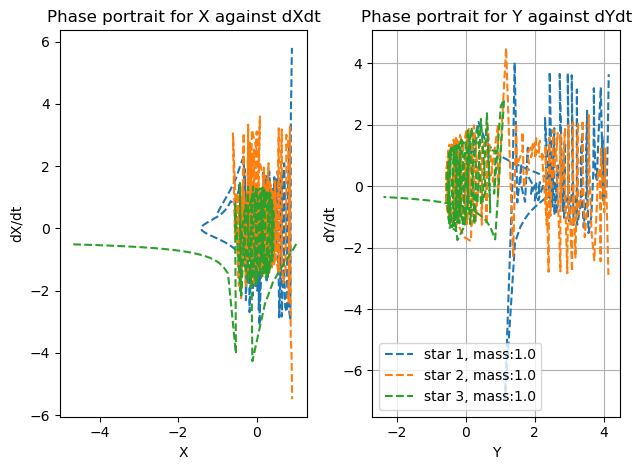

In [12]:
starA = Star(position = np.array([-1,0]), velocity = np.array([0.5,0.5]))

starB = Star(position = np.array([0,0]), velocity = np.array([-0.2,-0.1]))

starC = Star(position = np.array([1,0]), velocity = np.array([-0.5,0]))

starlist = [starA,starB,starC]

system2 = StellarSystem()
system2.add_star(starlist)

system2.calculate_trajectories(lifetime= 30.0, N_time_steps= 300)

system2.plot_trajectories(title = 'Trisolaris gone wrong')
system2.plot_phase_portrait()

## Class Definition for Hypergiant

HyperGiant class inherits everything from Star class including attributes and method setters. It also includes an addition method which will be used when two hypergiants collide

In [13]:
class HyperGiant(Star):
    """
    Defines HyperGiant object (a type of star) which will work within a stellar system. 
    The hypergiant will behave differently within a stellar system compared to other stars
    
    Attributes: mass (float), position (vector ndarry), velocity (vector ndarray)
    
    Methods: properties and attribute setters inherited from Star class
    
    Hypergiant addition will calculate resultant velocity and direction of hypergiant after collision
    
    """    
    # constructor function
    def __init__(self, mass=1.0, position=None, velocity=None):
        # Inherits all methods and attributes from Star class
        super().__init__(mass, position, velocity)
        
    def __add__(self, other):
        assert isinstance(self, HyperGiant) and isinstance(other, HyperGiant), 'Only Hypergiants can be added together'
        
        new_position =  (self.position+other.position)/2
        new_mass = self.mass + other.mass
        new_velocity = (self.mass*self.velocity + other.mass*other.velocity)/new_mass
        
        new_hypergiant = HyperGiant(mass = new_mass, position=new_position, velocity=new_velocity)
        
        return new_hypergiant
    
    def check_for_collision(self, other):
        if not (isinstance(self, HyperGiant) and isinstance(other, HyperGiant)):
            return False
        
        vector_between_stars = np.linalg.norm(self.position-other.position) # finding l2 norm distance between hypergiants
        if vector_between_stars <= self.mass+other.mass/10:
            return True
        else:
            return False
            #resultant_star = self+other
        
        
        
        

In [16]:
hyperboi = HyperGiant(3.0,np.array([0,1]))
hyperboi2 = HyperGiant(2.0,velocity=np.array([1,2]))

print(hyperboi.velocity, hyperboi2.mass)

hyperboi3 = hyperboi + hyperboi2
print(hyperboi3.velocity, hyperboi3.mass)
# hyperboi3 = hyperboi + starA  # RAISES assertion error as expected

[0. 0.] 2.0
[0.4 0.8] 5.0


## Scenario 3 : 3 Hypergiants with similar masses
set up initial conditions so that you have 3 hypergiants initially, and a few orbits are obtained before a merger of two of the objects. The hypergiants should have 3 similar but different masses, e.g. a ratio of 0.8 : 1.0 : 1.2

It's a pretty massive pain to set this up and I haven't really got it working. I am trying to edit the midpoint method to check for a collision at the end of every time step.

This checks for a collision by looping through the y_solution[itime] at current time. It extracts the position of each star and checks whether any are within a minimum collision distance. If it detects a collision has occured it will stop the equation at that time step, take the stars which have collided and return a new system with new initial conditions of the combined star and remaining star, it also finishes the simulation for the remaining lifetime and same delta_t.

With the 2 or more y solution partitions of the original lifetime, it would then be required to stitch them together in a plot, but as they would have different number of stars my current implementation of plotting would have to be amended 

Stellar system needs at least two stars to be defined
System is defined!
Trajectories have been calculated, use .plot_trajectories() to visualise


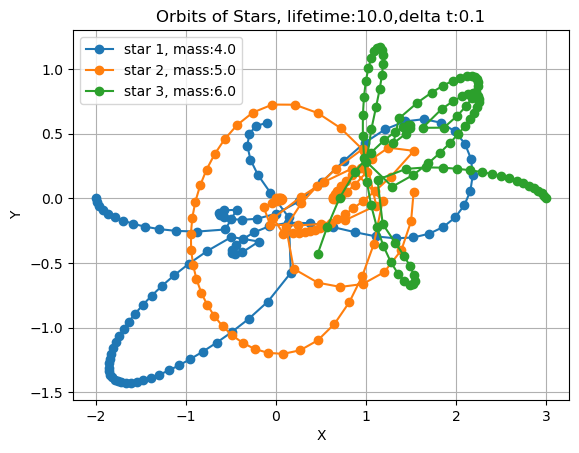

In [ ]:
hypergiantA = HyperGiant(mass=4.0, position= np.array([-2,0]), velocity= np.array([0.05,-0.3]))
hypergiantB = HyperGiant(mass=5.0, position= np.array([0,0]), velocity= np.array([0.2,0]))
hypergiantC = HyperGiant(mass=6.0, position= np.array([3,0]), velocity= np.array([-0.2,0.2]))

star_list = [hypergiantA, hypergiantB, hypergiantC]

system3 = StellarSystem()

system3.add_star(star_list)

system3.calculate_trajectories()

system3.plot_trajectories()



In [ ]:




def midpoint(lifetime =10.0, N_time_steps = 100):
    lifetime =lifetime
    delta_t = lifetime / N_time_steps
    t_solution = np.linspace(0.0, lifetime, N_time_steps+1) # values of independent variable 
    y0 = system3.return_initial_conditions() # initial values y0
    
    y_solution = np.zeros((N_time_steps+1, len(y0)))
    
    for itime, time in enumerate(t_solution) :
        if itime == 0 :
            # Sets initial time point to y0
            y_solution[itime] = y0
            old_time = time
        else :
            dydt_at_t = StellarSystem.calculate_accelerations_dydt(old_time, y_solution[itime-1])
            
            y_t_plus_half = (y_solution[itime-1] + 0.5 *
                                    dydt_at_t * delta_t)
            
            t_plus_half = old_time + 0.5*delta_t
            
            dydt_at_t_plus_half = StellarSystem.calculate_accelerations_dydt(t_plus_half, y_t_plus_half)
            
            y_solution[itime] = (y_solution[itime-1] + 
                                    dydt_at_t_plus_half * delta_t) 
            old_time = time
        
        # if check_collision(y_solution, itime):
        
    # Transpose solutions to correct orientation, initialised in transposed shape to make manipulation easier        
    y_solution = y_solution.T

def check_collision(y_solution, itime, lifetime, time, N_time_steps):
    for i in range(3):
        for j in range(i+1,3):
        
            istarPos = y_solution[itime][4*i:4*i+2] #extract positions
            jstarPos = y_solution[itime][4*j:4*j+2]
            distance_between_stars = np.linalg.norm(jstarPos-istarPos)
            
            MinRadius = (star_list[i].mass + star_list[j].mass)/10
            
            if distance_between_stars < MinRadius: # this checks all stars and will count the same collision twice, so all we need is a condition to be fulfilled once
                    # this means we need to account for this and initialise a whole new system
                    
                    
                    new_lifetime = lifetime-time
                    new_n_time_steps = N_time_steps-itime